In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
sys.path.append("/workspace/localizing-edm/")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchinfo import summary

import torch
import dnnlib
import pickle
import pandas as pd
import numpy as np

model_root = '/workspace/localizing-edm/workdir/runs'
model_file = f"{model_root}/finetune_cifar/00007-mvtec_hazelnut-uncond-ncsnpp-ve-gpus1-batch128-fp32/network-snapshot-020019.pkl"
device = torch.device('cuda')

with dnnlib.util.open_url(model_file) as f:
    net = pickle.load(f)['ema'].to(device)

model_file

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/workspace/localizing-edm/workdir/runs/finetune_cifar/00007-mvtec_hazelnut-uncond-ncsnpp-ve-gpus1-batch128-fp32/network-snapshot-020019.pkl'

In [17]:
from scorer import VEScorer, plot_score_grid
from flows import ScoreFlow, build_model, log_density
from torch.nn.functional import interpolate

In [5]:
from training.dataset import MVTecDataset

mvtec_ds = MVTecDataset(path="/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut", train=False, resolution=64)
inlier_batch, _ = mvtec_ds.load_test(only_normal=True)
ood_batch, mask = mvtec_ds.load_test(skip_normal=True)
inlier_batch = torch.stack(inlier_batch).cuda() / 127.5 - 1
ood_batch = torch.stack(ood_batch).cuda() / 127.5 - 1
mask = torch.stack(mask).cuda()
inlier_batch.shape, ood_batch.shape, ood_batch.dtype 

(torch.Size([40, 3, 64, 64]), torch.Size([70, 3, 64, 64]), torch.float32)

In [18]:
num_steps = 10
device = torch.device("cuda")
conv_inn = build_model((num_steps, mvtec_ds.resolution, mvtec_ds.resolution))
flownet = ScoreFlow(conv_inn, net, num_steps).to(device)
summary(flownet, input_data=torch.ones(1,3, mvtec_ds.resolution, mvtec_ds.resolution))

Layer (type:depth-idx)                        Output Shape              Param #
ScoreFlow                                     [1, 40, 32, 32]           --
├─VEScorer: 1-1                               [1, 10, 64, 64]           --
│    └─SongUNet: 2-1                          [1, 3, 64, 64]            2,304
│    │    └─FourierEmbedding: 3-1             [1, 256]                  --
│    │    └─Linear: 3-2                       [1, 512]                  (131,584)
│    │    └─Linear: 3-3                       [1, 512]                  (262,656)
│    │    └─ModuleDict: 3-49                  --                        (recursive)
│    │    └─ModuleDict: 3-50                  --                        (recursive)
│    └─SongUNet: 2-2                          [1, 3, 64, 64]            (recursive)
│    │    └─FourierEmbedding: 3-6             [1, 256]                  --
│    │    └─Linear: 3-7                       [1, 512]                  (recursive)
│    │    └─Linear: 3-8                   

In [19]:
flow_path = f"/workspace/localizing-edm/workdir/runs/cifar-base/v1/checkpoint.pth"
state_dict = torch.load(flow_path)
flownet.load_state_dict(state_dict["model_state_dict"])
print("Loaded")

Loaded


In [20]:
scores = flownet.scorenet(ood_batch[:9]).cpu()
scores.shape

torch.Size([9, 10, 64, 64])

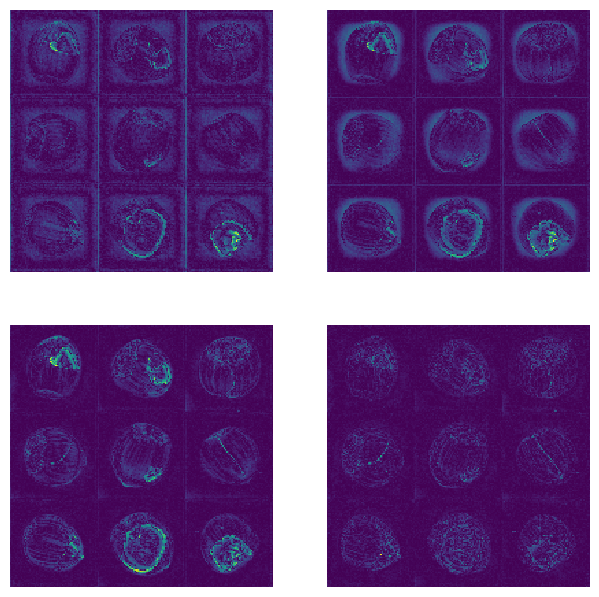

In [21]:
plot_score_grid(scores, plot_sigma_idxs = [1, 3, 5, 7, 9])

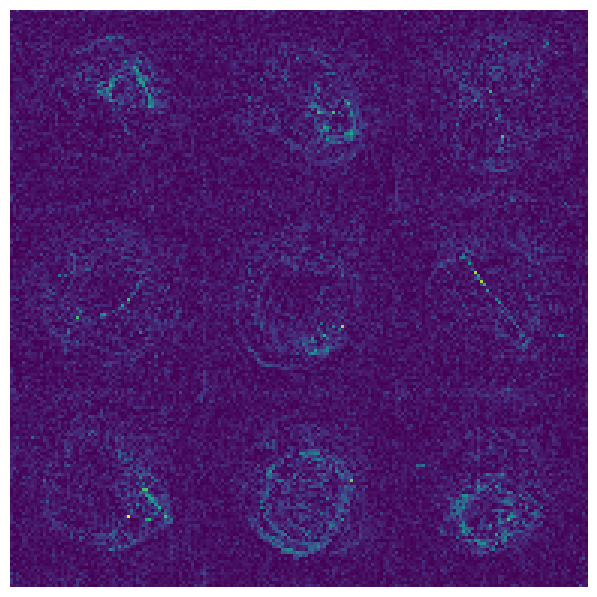

In [22]:
plot_score_grid(scores.sum(dim=1, keepdims=True), plot_sigma_idxs = [0])

In [23]:
%%time
logpx = log_density(flownet, ood_batch[:9])

CPU times: user 269 ms, sys: 146 ms, total: 415 ms
Wall time: 414 ms


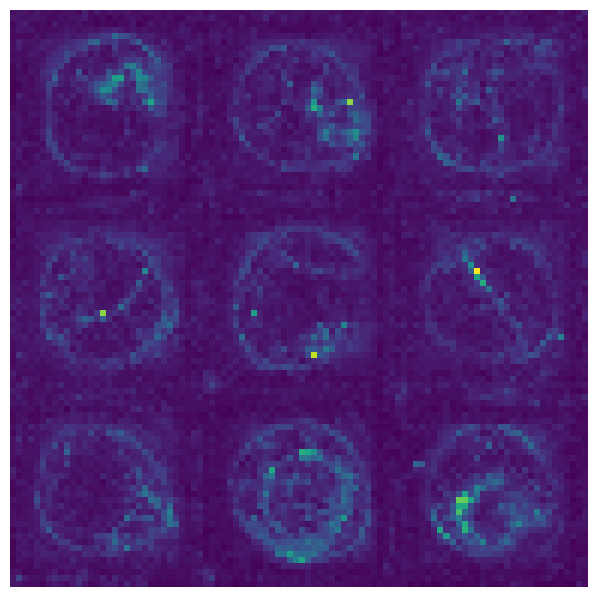

In [24]:
plot_score_grid(logpx, plot_sigma_idxs=[0])

In [25]:
heatmap = interpolate(logpx, scale_factor=2**6, mode="bilinear", align_corners=False)
heatmap.shape

torch.Size([9, 1, 2048, 2048])

In [26]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.colors as colors

def plot_batch_with_heatmaps(images_batch, anomaly_maps, grid_size=(5, 5),
                             alpha=0.5, symmetric_norm=True, linthresh_q=0.9):
    # Ensure anomaly_maps have an additional dimension for color channel
#     anomaly_maps = anomaly_maps.unsqueeze(-1)
    anomaly_maps = - anomaly_maps.squeeze(1)
    amin = anomaly_maps.min(axis=(1,2), keepdims=True)
    amax = anomaly_maps.max(axis=(1,2), keepdims=True) 
    anomaly_maps = (anomaly_maps - amin / (amax-amin))
    
    if symmetric_norm:
        norm=colors.SymLogNorm(linthresh=np.quantile(anomaly_maps,linthresh_q),
                               vmin=np.quantile(anomaly_maps,0.01),
                               vmax=np.quantile(anomaly_maps,0.99))
    else:
        norm=colors.LogNorm(vmin=np.quantile(anomaly_maps,0.01),
                            vmax=np.quantile(anomaly_maps,0.99))
    shape = anomaly_maps.shape
    anomaly_maps  = norm(anomaly_maps.ravel()).reshape(*shape)
    
    # Expand anomaly_maps to 3 color channels and apply colormap
    anomaly_maps_rgb = plt.get_cmap('Reds')(anomaly_maps)[:,:,:,:3]
    print(anomaly_maps_rgb.shape)
    anomaly_maps_rgb = torch.from_numpy(anomaly_maps_rgb).float()
    anomaly_maps_rgb = anomaly_maps_rgb.permute(0,3,1,2)
    
    # Merge images with anomaly maps with given alpha
    overlaid_images = alpha * images_batch + (1-alpha) * anomaly_maps_rgb
    print(overlaid_images.shape)
    # Convert batch of tensors to grid
    grid = vutils.make_grid(overlaid_images, nrow=grid_size[1], padding=2, normalize=True)
    
    # Plot grid
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(np.transpose(grid.numpy(),(1,2,0)))
    
    return anomaly_maps_rgb

In [27]:
# assuming images_batch and anomaly_maps are your data
batch_size = 9
images_batch = ood_batch[:batch_size].cpu()
heatmap = interpolate(logpx[:batch_size], scale_factor=2, mode="bilinear", align_corners=False).cpu().numpy()

(9, 64, 64, 3)
torch.Size([9, 3, 64, 64])


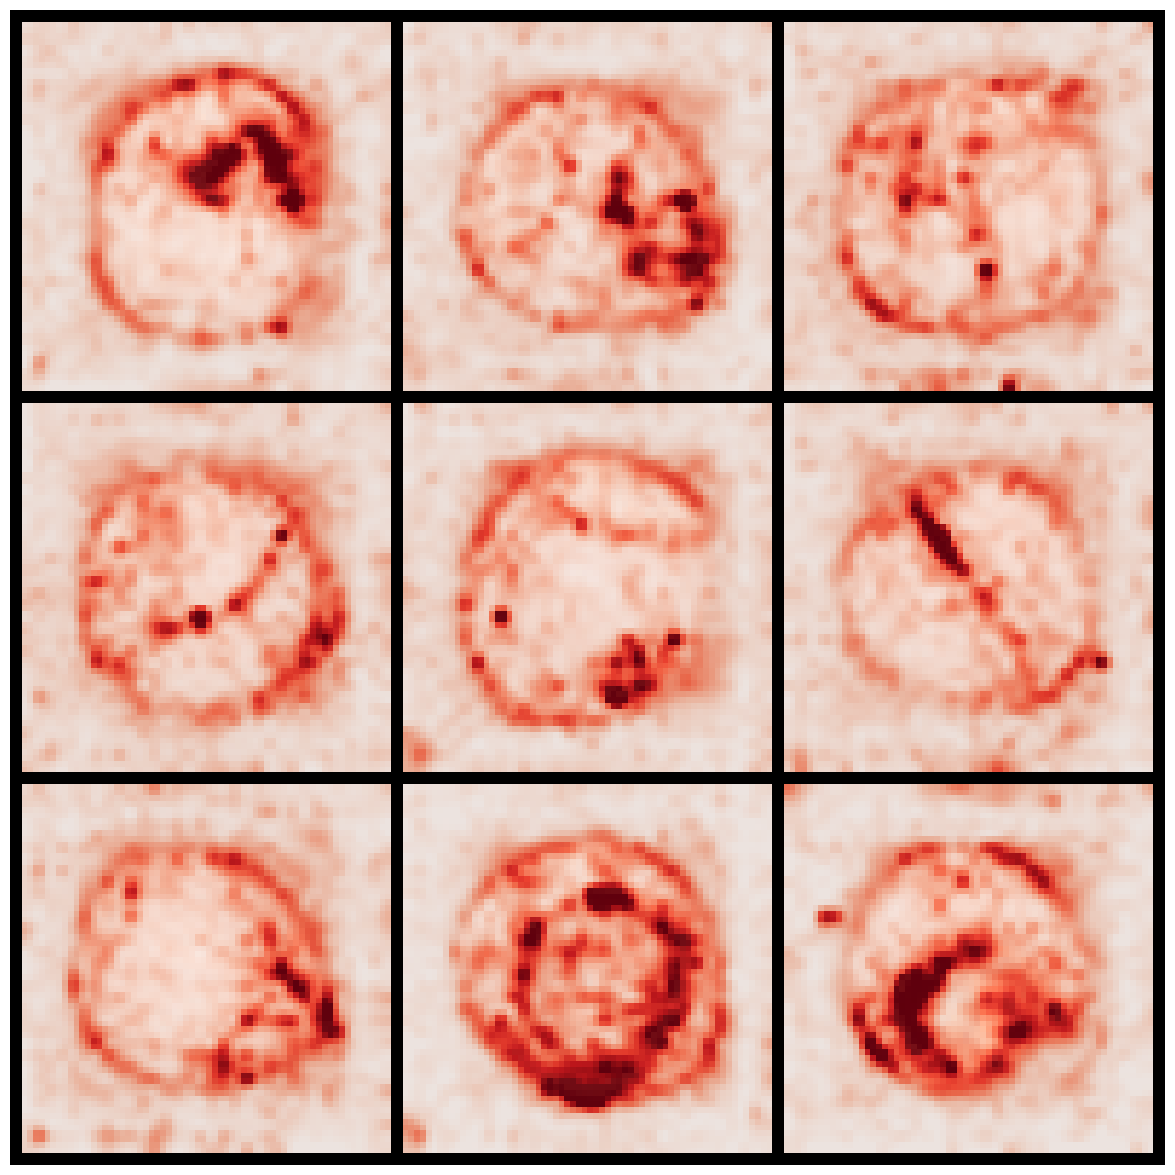

In [28]:
# define grid size and alpha for heatmap opacity
grid_size = (3, 3)
alpha = 0.05

# Call the function with the RGB image batch and the anomaly maps batch
ano = plot_batch_with_heatmaps(images_batch, heatmap, grid_size, alpha, linthresh_q=0.99)